In [1]:
import pandas as pd
from datetime import datetime
import numpy
import math
import sys
import statsmodels.tsa.stattools as st
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


/Users/chronowanderer/anaconda3/envs/tensorflow/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
FORECAST_MAX = 10
TRAIN_SIZE = 100
look_back = TRAIN_SIZE - 1
EFFECTIVENESS = 0.25
EFFECTIVE_LOC = int(TRAIN_SIZE / EFFECTIVENESS)


In [3]:
def atan_positive(x, y):
    if (x > 0) & (y > 0):
        theta = math.atan(y / x)
    elif (x == 0) & (y > 0):
        theta = math.pi / 2
    elif (x < 0):
        theta = math.pi + math.atan(y / x)
    elif (x == 0) & (y < 0):
        theta = 3 * math.pi / 2
    elif (x > 0) & (y <= 0):
        theta = 2 * math.pi + math.atan(y / x)
    return theta

def brwnm2(mu1, mu2, a, sigma, h, lentmax):
    locRT = 0
    theta_T = 999
    x = mu1 * h + sigma * numpy.random.randn(lentmax) * math.sqrt(h)
    y = mu2 * h + sigma * numpy.random.randn(lentmax) * math.sqrt(h)
    a_r = a - math.sqrt(h) * sigma / 2.0
    x_start = 0.0
    y_start = 0.0
    w = [x_start]
    z = [y_start] 
    flag = 0
    for k in numpy.arange(1, lentmax):
        w.append(w[k - 1] + x[k])
        z.append(z[k - 1] + y[k])
        if (flag == 0) & (w[k] ** 2 + z[k] ** 2 >= a_r ** 2):
            locRT = k
            theta_T = atan_positive(w[k], z[k]) / 2.0
            flag = 1
    return (w, z, theta_T, locRT)

def semicircular_error(r, t):
    e = r - t
    if e >= 90:
        e = e - 180
    elif e < -90:
        e = e + 180
    return e


In [4]:
def test_stationarity(timeseries):
    dftest = adfuller(timeseries, autolag='BIC')
    return dftest[1]

def best_diff(df, maxdiff = 2):
    p_set = {}
    for i in range(0, maxdiff + 1):
        temp = df.copy()
        if i == 0:
            temp['diff'] = temp[temp.columns[0]]
        else:
            temp['diff'] = temp[temp.columns[0]].diff(i)
            temp = temp.drop(temp.iloc[:i].index)
        pvalue = test_stationarity(temp['diff'])
        p_set[i] = pvalue
        p_df = pd.DataFrame.from_dict(p_set, orient="index")
        p_df.columns = ['p_value']
    i = 0
    bestdiff = maxdiff
    while i < len(p_df):
        if p_df['p_value'][i] < 0.01:
            bestdiff = i
            break
        i = i + 1
    return bestdiff

def ARIMA_prediction(input_ts, forward, maxLag = 5):
    ts_series = pd.Series(input_ts)
    ts_dataframe = pd.DataFrame(ts_series, columns = ['loc'], index = range(len(input_ts)))
    best_df = best_diff(ts_dataframe)
    timeseries = ts_dataframe
    timeseries.index = pd.to_datetime(timeseries.index, unit = 'ms')
    init_bic = sys.maxint
    init_p = 0
    init_q = 0
    init_properModel = None
    for p in range(maxLag):
        for q in range(maxLag):
            model = ARIMA(timeseries, order = (p, best_df, q))
            try:
                results_ARIMA = model.fit(disp = -1, method = 'css')
            except:
                continue
            bic = results_ARIMA.bic
            if bic < init_bic:
                init_p = p
                init_q = q
                init_properModel = results_ARIMA
                init_bic = bic
    forecast_ts = init_properModel.forecast(forward, alpha=0.05)[0]
    forecast_ts = numpy.array(forecast_ts)
    return forecast_ts


In [5]:
numSeries = 1 # training & testing & sequently predicting
numPredict = 1
tmax = 2.0
h = 0.001
lentmax = int(tmax / h)
T = numpy.linspace(0, tmax, lentmax, endpoint = False)
DATA_i = 0
DATA_f = lentmax - 1
norm, a, sigma = [], [], []
Target, Response, Error, RTloc = [], [], [], []
Dat = []

i = 0
while i < (numSeries + numPredict):
    norm0 = numpy.random.uniform(0.1, 10)
    a0 = numpy.random.uniform(0.1, 10)
    sigma0 = numpy.random.uniform(0.1, 10)
    RESP = numpy.random.randint(0, 180)
    if RESP == 0:
        RESP = 180;
    mu1 = norm0 * math.cos(2 * RESP * math.pi / 180)
    mu2 = norm0 * math.sin(2 * RESP * math.pi / 180)
    (L_x, L_y, theta, t_loc) = brwnm2(mu1, mu2, a0, sigma0, h, lentmax)
    if t_loc >= EFFECTIVE_LOC:
        norm.append(norm0)
        a.append(a0)
        sigma.append(sigma0)
        Target.append(RESP)
        Response.append(theta / math.pi * 180)
        Error.append(semicircular_error(theta / math.pi * 180, RESP))
        RTloc.append(t_loc)
        temp = []
        for j in numpy.arange(lentmax):
            temp.append([L_x[j], L_y[j]])
        Dat.append(temp)
        i = i + 1

Dat = numpy.array(Dat) # all data
Data = Dat[0 : numSeries, :, :] # training & testing & sequently predicting

dataset = []
for i in numpy.arange(numSeries):
    for j in numpy.arange(lentmax):
        dataset.append(Data[i, j])
dataset = numpy.array(dataset)

print dataset.shape
print (norm[0], a[0], sigma[0], Target[0])


(2000, 2)
(1.4682537036033534, 6.996038869036361, 5.878661874640053, 5)


In [6]:
TOTAL_TIME = Data.shape[1]
lentmax = TOTAL_TIME

# split into train and test sets
train_size = TRAIN_SIZE
test_size = TOTAL_TIME - train_size + look_back
train, test = [], []
for k in range(numSeries):
    kk = k * TOTAL_TIME
    for t in range(kk, kk+train_size):
        train.append(dataset[t, :])
    for t in range(kk+train_size-look_back, kk+TOTAL_TIME):
        test.append(dataset[t, :])
train = numpy.array(train)
test = numpy.array(test)
        
print train.shape, test.shape

# use this function to prepare the train and test datasets for modeling
trainX, trainY = [], []
for k in range(numSeries):
    kk = k * train_size
    for i in range(train_size - look_back):
        temp = train[(kk + i) : (kk + i + look_back), :]
        trainX.append(temp)
        trainY.append(train[kk + i + look_back, :])
trainX = numpy.array(trainX)
trainY = numpy.array(trainY)

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], look_back, trainX.shape[2]))


(100, 2) (1999, 2)


In [7]:
# make predictions
trainScore, testScore = [], []
TRAIN_PREDICT_x, TRAIN_PREDICT_y = [], []
NumEffectivePrediction, ResponsePredictionScore, RTPredictionScore = [], [], []
for s in range(numSeries):
    TRAIN_PREDICT_x.append(ARIMA_prediction(trainX[s, :, 0], FORECAST_MAX))
    TRAIN_PREDICT_y.append(ARIMA_prediction(trainX[s, :, 1], FORECAST_MAX))
TRAIN_PREDICT_x = numpy.array(TRAIN_PREDICT_x)
TRAIN_PREDICT_y = numpy.array(TRAIN_PREDICT_y)

for FORECAST_STEP in range(1, FORECAST_MAX + 1):
    print('%d -step(s) forecast:' % (FORECAST_STEP))
    
    trainPredictPlot = numpy.empty_like(Data)
    trainPredictPlot[:, :, :] = numpy.nan
    testPredictPlot = numpy.empty_like(Data)
    testPredictPlot[:, :, :] = numpy.nan
    
    testX, testY = [], []
    trainPredict, testPredict = [], []
    for k in range(numSeries):       
        kk = k * test_size
        for i in range(test_size - look_back - FORECAST_STEP + 1):
            temp = test[(kk + i) : (kk + i + look_back), :]
            testX.append(temp)
            testY.append(test[kk + i + look_back + FORECAST_STEP - 1, :])
        trainPredict_x = TRAIN_PREDICT_x[k][FORECAST_STEP - 1]
        trainPredict_y = TRAIN_PREDICT_y[k][FORECAST_STEP - 1]
        trainPredict.append([trainPredict_x, trainPredict_y])        
    
    trainPredict = numpy.array(trainPredict)       
    testX = numpy.array(testX)
    testY = numpy.array(testY)
    
    for k in range(numSeries):
        for i in range(test_size - look_back - FORECAST_STEP + 1):
            temp = testX[k * (test_size - look_back - FORECAST_STEP + 1) + i, :, 0]
            testPredict_x = ARIMA_prediction(temp, FORECAST_MAX)[FORECAST_STEP - 1]
            temp = testX[k * (test_size - look_back - FORECAST_STEP + 1) + i, :, 1]
            testPredict_y = ARIMA_prediction(temp, FORECAST_MAX)[FORECAST_STEP - 1]
            testPredict.append([testPredict_x, testPredict_y])
    testPredict = numpy.array(testPredict) 
    
    trainScore.append(math.sqrt(mean_squared_error(trainY, trainPredict)))
    print('Train Score: %.4f RMSE' % (trainScore[FORECAST_STEP - 1]))
    testScore.append(math.sqrt(mean_squared_error(testY, testPredict)))
    print('Test Score: %.4f RMSE' % (testScore[FORECAST_STEP - 1]))
    
    for k in range(numSeries):
        # shift train predictions for plotting
        for t in range(train_size - look_back):
            trainPredictPlot[k, t + look_back , :] = trainPredict[t + k * (train_size - look_back), :]
        # shift test predictions for plotting
        for t in range(test_size - look_back - FORECAST_STEP + 1):
            testPredictPlot[k, t + TRAIN_SIZE + FORECAST_STEP - 1, :] = testPredict[t + k * (test_size - look_back - FORECAST_STEP + 1), :]
    
    Observed_theta, Observed_error, Observed_locRT = [], [], []
    Estimated_theta, Estimated_error, Estimated_locRT = [], [], []
    for s in range(numSeries):
        a_r = a[s] - math.sqrt(h) * sigma[s] / 2.0
        for k in range(lentmax):
            temp = testPredictPlot[s, k, :]
            if (temp[0] ** 2 + temp[1] ** 2 >= a_r ** 2):
                Observed_locRT.append(RTloc[s])
                Estimated_locRT.append(k)
                Observed_theta.append(Response[s])
                tt = atan_positive(temp[0], temp[1]) / 2.0 / math.pi * 180
                Estimated_theta.append(tt)
                Observed_error.append(Error[s])
                Estimated_error.append(semicircular_error(tt, Target[s]))
                break
    print len(Observed_error)

    Res0 = [i * math.pi / 180 for i in Observed_error]
    Res = [i * math.pi / 180 for i in Estimated_error]
    Err = Res
    NumEffectivePrediction.append(float(len(Err)) / numPredict)
    for i in range((len(Observed_error))):
        Err[i] = (semicircular_error(Estimated_error[i], Observed_error[i]) * math.pi / 180) ** 2
    if len(Err) == 0:
        ResponsePredictionScore.append(-233)
    else:
        ResponsePredictionScore.append(math.sqrt(sum(Err) / len(Err)))
    RT0 = [i * h for i in Observed_locRT]
    RT = [i * h for i in Estimated_locRT]
    RTPredictionScore.append(math.sqrt(mean_squared_error(RT0, RT)))
            
    print('Error Estimation Score: %.4f RMSE' % (ResponsePredictionScore[FORECAST_STEP - 1]))
    print('RT Estimation Score: %.4f RMSE' % (RTPredictionScore[FORECAST_STEP - 1]))


1 -step(s) forecast:
Train Score: 0.3432 RMSE
Test Score: 0.1896 RMSE
1
Error Estimation Score: 0.0017 RMSE
RT Estimation Score: 0.0000 RMSE
2 -step(s) forecast:
Train Score: 0.3732 RMSE
Test Score: 0.2688 RMSE
1
Error Estimation Score: 0.0011 RMSE
RT Estimation Score: 0.0010 RMSE
3 -step(s) forecast:
Train Score: 0.4036 RMSE
Test Score: 0.3336 RMSE
1
Error Estimation Score: 0.0256 RMSE
RT Estimation Score: 0.0010 RMSE
4 -step(s) forecast:
Train Score: 0.4341 RMSE
Test Score: 0.3877 RMSE
1
Error Estimation Score: 0.0260 RMSE
RT Estimation Score: 0.0020 RMSE
5 -step(s) forecast:
Train Score: 0.4649 RMSE
Test Score: 0.4369 RMSE
1
Error Estimation Score: 0.0265 RMSE
RT Estimation Score: 0.0030 RMSE
6 -step(s) forecast:
Train Score: 0.4957 RMSE
Test Score: 0.4808 RMSE
1
Error Estimation Score: 0.0270 RMSE
RT Estimation Score: 0.0040 RMSE
7 -step(s) forecast:
Train Score: 0.5267 RMSE
Test Score: 0.5200 RMSE
1
Error Estimation Score: 0.0274 RMSE
RT Estimation Score: 0.0050 RMSE
8 -step(s) fo

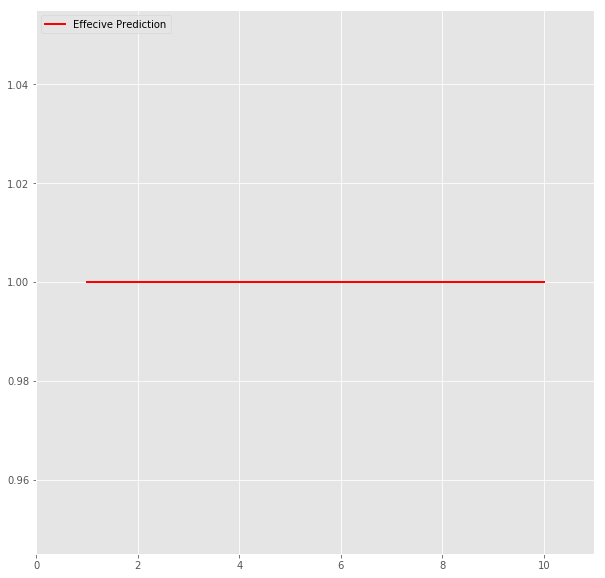

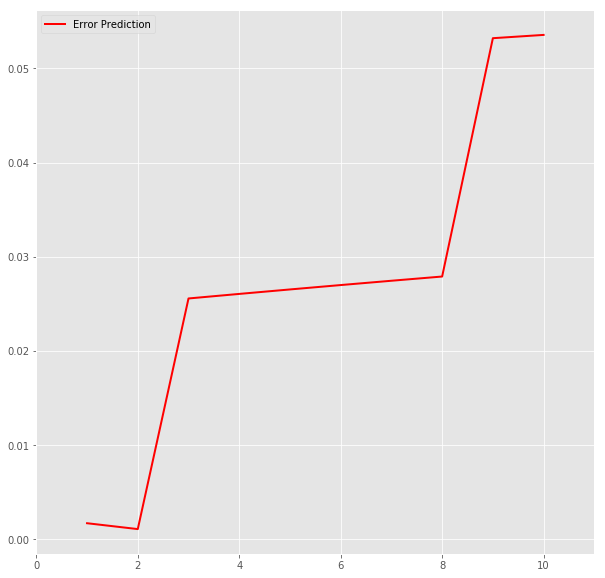

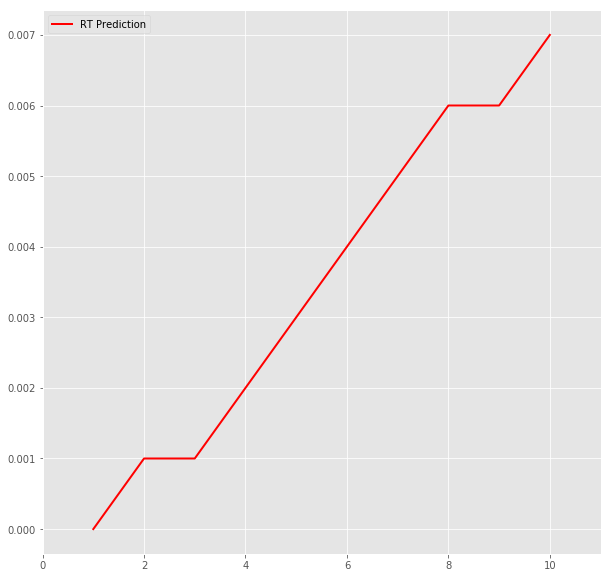

In [8]:
NumEffectivePrediction = numpy.array(NumEffectivePrediction)
ResponsePredictionScore = numpy.array(ResponsePredictionScore)
RTPredictionScore = numpy.array(RTPredictionScore)

xx = numpy.arange(1, FORECAST_MAX + 1)

plt.figure(figsize=(10, 10))
plt.style.use('ggplot')
plt.xlim(0, FORECAST_MAX + 1)
EffectivePredictionPlot = plt.plot(xx, NumEffectivePrediction, linewidth = 2, color = 'r', label = "Effecive Prediction")
plt.legend(handles=[EffectivePredictionPlot[0]],loc="upper left")
plt.show()

plt.figure(figsize=(10, 10))
plt.style.use('ggplot')
plt.xlim(0, FORECAST_MAX + 1)
ResponsePredictionPlot = plt.plot(xx, ResponsePredictionScore, linewidth = 2, color = 'r', label = "Error Prediction")
plt.legend(handles=[ResponsePredictionPlot[0]],loc="upper left")
plt.show()

plt.figure(figsize=(10, 10))
plt.style.use('ggplot')
plt.xlim(0, FORECAST_MAX + 1)
RTPredictionPlot = plt.plot(xx, RTPredictionScore, linewidth = 2, color = 'r', label = "RT Prediction")
plt.legend(handles=[RTPredictionPlot[0]],loc="upper left")
plt.show()
